# Black Hat USA Training (Early draft)

## Lab 3: Dynamic Malware Detection using Transformer Neural Networks

We will follow a "Top-Down" teaching methodology: We will start with higher level concepts familiar to our students in the cybersecurity domain, for instance, by introducing a specific library and demonstrating its use. Then, we delve deeper into the methods and parameters of these applications. Finally, we explore the underlying fundamentals, such as the specific PE format properties or mathematical concepts at the core of these ideas.

**NOTE: This is a raw draft that will be populated with more material (especially visual) and explanations, especially, facilitating more gradual AI/ML concept introduction.**

Contents:

- Download PlugX Sample
- Machine Learning with Dynamic Malware Analysis 
- Speakeasy Emulator
- PyTorch Introduction

In [ ]:
%pip install git+https://github.com/dtrizna/nebula

In [4]:
# force reimport of lab_helpers
import sys
if 'lab_helpers' in sys.modules:
    del sys.modules['lab_helpers']

from lab_helpers import *

## Download PlugX Sample

<img src="img/plugx_vt.png" width=600>

In [6]:
# NOTE: for some reason download from vx-underground is denied by the server 
# works from browser, but not if using requests.get, user-agent browser mimic does not help
vx_link = "https://samples.vx-underground.org/Samples/Families/PlugX/0D219AA54B1D417DA61BD4AED5EEB53D6CBA91B3287D53186B21FED450248215.7z"
# using a private hosted copy
local_path = "http://20.185.144.222/0D219AA54B1D417DA61BD4AED5EEB53D6CBA91B3287D53186B21FED450248215.7z"
plugx_rat_bytez = get_encrypted_archive(local_path, password="infected")
print(plugx_rat_bytez[0:20])

b'MZP\x00\x02\x00\x00\x00\x04\x00\x0f\x00\xff\xff\x00\x00\xb8\x00\x00\x00'


## Machine Learning Model with Dynamic Malware Analysis 

In [7]:
import nebula

nebula_transformer = nebula.Nebula(tokenizer='bpe')
plugx_rat_report = nebula_transformer.dynamic_analysis_pe_file(plugx_rat_bytez)

print("[!] First 5 API calls invoked by PlugX RAT:\n")
_ = [print(val) for val in plugx_rat_report['apis'][0:5]]

[!] First 5 API calls invoked by PlugX RAT:

{'api_name': 'kernel32.GetModuleHandleA', 'args': ['0x0'], 'ret_val': '0x400000'}
{'api_name': 'user32.GetKeyboardType', 'args': ['0x0'], 'ret_val': '0x4'}
{'api_name': 'kernel32.GetCommandLineA', 'args': [], 'ret_val': '0x45f0'}
{'api_name': 'kernel32.GetStartupInfoA', 'args': ['0x1211f30'], 'ret_val': None}
{'api_name': 'kernel32.GetVersion', 'args': [], 'ret_val': '0x1db10106'}


In [8]:
plugx_dynamic_features = nebula_transformer.preprocess(plugx_rat_report)

print(f"[!] Shape of dynamic features: {plugx_dynamic_features.shape}\n")

print(f"[!] First 5 dynamic features:\n\n{plugx_dynamic_features[0, 0:20]}")

[!] Shape of dynamic features: (1, 512)

[!] First 5 dynamic features:

[ 2235  1036   530  1203   778  1078   125  1103 15492 49966   932   530
  1203   778   560  1176  1103 15492 49966   932]


In [9]:
import torch
torch.manual_seed(0)
prob = nebula_transformer.predict_proba(plugx_dynamic_features)

hhash = vx_link.split("/")[-1].split(".")[0].lower()
print(f"[!] Probability malware: {prob*100:>5.2f}% | File: {hhash}")

if os.path.exists(r"C:\windows\system32\calc.exe"):
    with open (r"C:\windows\system32\calc.exe", "rb") as f:
        calc_bytez = f.read()

    report = nebula_transformer.dynamic_analysis_pe_file(calc_bytez)
    dynamic_features = nebula_transformer.preprocess(report)
    
    prob = nebula_transformer.predict_proba(dynamic_features)
    print(f"[!] Probability malware: {prob*100:>5.2f}% | File: calc.exe")

[!] Probability malware: 92.13% | File: 0d219aa54b1d417da61bd4aed5eeb53d6cba91b3287d53186b21fed450248215
[!] Probability malware:  0.66% | File: calc.exe


## Speakeasy Emulator

How this is achieved under the hood?

Speakeasy is a Python-based emulator build and actively maintained by Mandiant.

It is built on top of the Unicorn emulator framework, and emulated x86 architecture solely with a focus on malware analysis.


In [10]:
import speakeasy
emulator = speakeasy.Speakeasy()

module = emulator.load_module(data=plugx_rat_bytez)
emulator.run_module(module)
report = emulator.get_report()

# drop report to disk
import json
with open("plugx_report.json", "w") as f:
    json.dump(report, f, indent=4)

Observe `plugx_report.json` file.

In [11]:
api_nr = len(report['entry_points'][0]['apis'])
print(f"Number of API calls invoked by PlugX RAT: {api_nr}")

Number of API calls invoked by PlugX RAT: 197


In [12]:
_ = [print(val) for val in report['entry_points'][0]['apis'][0:5]]

{'pc': '0x4069ad', 'api_name': 'kernel32.GetModuleHandleA', 'args': ['0x0'], 'ret_val': '0x400000'}
{'pc': '0x40398a', 'api_name': 'user32.GetKeyboardType', 'args': ['0x0'], 'ret_val': '0x4'}
{'pc': '0x406870', 'api_name': 'kernel32.GetCommandLineA', 'args': [], 'ret_val': '0x45f0'}
{'pc': '0x401333', 'api_name': 'kernel32.GetStartupInfoA', 'args': ['0x1211f30'], 'ret_val': None}
{'pc': '0x406884', 'api_name': 'kernel32.GetVersion', 'args': [], 'ret_val': '0x1db10106'}


In [13]:
error_type = report['entry_points'][0]['error']['type']
api = report['entry_points'][0]['error']['api_name']
print(f"Error type: {error_type} | API: '{api}'")

Error type: unsupported_api | API: 'gdi32.GetSystemPaletteEntries'


We got the same values as the ones we got from the `nebula` analysis above. In reality, Speakeasy has extra fields that are a potential source of information for our model.

In [14]:
report['entry_points'][0]['registry_access']

[{'event': 'open_key',
  'path': 'HKEY_CURRENT_USER\\Software\\Borland\\Locales'},
 {'event': 'open_key',
  'path': 'HKEY_LOCAL_MACHINE\\Software\\Borland\\Locales'},
 {'event': 'open_key',
  'path': 'HKEY_CURRENT_USER\\Software\\Borland\\Delphi\\Locales'}]

Speakeasy is adjustable tool and supports a variety of configurations, for instance, it is possible to modify environment variables, user and domain information, simulate network state, and more.

In [19]:
speakeasy_config = os.path.join(os.path.dirname(nebula.__file__), "objects", "speakeasy_config.json")

with open(speakeasy_config, "r") as f:
    speakeasy_config = json.load(f)

speakeasy_config['env']

{'comspec': 'C:\\Windows\\system32\\cmd.exe',
 'systemroot': 'C:\\Windows',
 'windir': 'C:\\Windows',
 'temp': 'C:\\Windows\\temp\\',
 'userprofile': 'C:\\Users\\dtrizna',
 'systemdrive': 'C:',
 'allusersprofile': 'C:\\ProgramData',
 'programfiles': 'C:\\Program Files'}

In [20]:
print(speakeasy_config['domain'])
print(speakeasy_config['user'])

foo.bar
{'name': 'dtrizna', 'is_admin': True}


In [21]:
speakeasy_config['network']

{'dns': {'names': {'work.foo.bar': '127.0.0.1',
   'foo.bar': '10.1.2.3',
   'default': '10.1.2.3',
   'google.com': '8.8.8.8',
   'localhost': '127.0.0.1'},
  'txt': [{'name': 'default', 'path': '$ROOT$/resources/web/default.bin'}]},
 'http': {'responses': [{'verb': 'GET',
    'files': [{'mode': 'default', 'path': '$ROOT$/resources/web/default.bin'},
     {'mode': 'by_ext',
      'ext': 'gif',
      'path': '$ROOT$/resources/web/decoy.gif'},
     {'mode': 'by_ext',
      'ext': 'jpg',
      'path': '$ROOT$/resources/web/decoy.jpg'}]}]},
 'winsock': {'responses': [{'mode': 'default',
    'path': '$ROOT$/resources/web/stager.bin'}]}}

In [63]:
# force reimport of lab_helpers
import sys
if 'lab_helpers' in sys.modules:
    del sys.modules['lab_helpers']

from lab_helpers import *

In [69]:
import os
from tqdm import tqdm
if not os.path.exists("Ransomware-Samples"):
    !git clone https://github.com/kh4sh3i/Ransomware-Samples

ransomware_samples = []
for root, dirs, files in os.walk("Ransomware-Samples"):
    for d in dirs:
        files = os.listdir(os.path.join(root, d))
        for f in files:
            if f.endswith(".zip"):
                ransomware_samples.append(os.path.join(root, d, f))

print(f"[!] Number of archives: {len(ransomware_samples)}")

ransomware_bytez = {}
for ransomware in tqdm(ransomware_samples, desc="[*] Decrypting"):
    bytez = get_encrypted_archive(ransomware, password="infected")
    ransomware_bytez.update(bytez)

l = len(ransomware_bytez)
print(f"[!] Number of ransomware samples: {l}")

[!] Number of archives: 18


[*] Decrypting: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]

[!] Number of ransomware samples: 33


In [73]:
import time
import gzip

import speakeasy.errors
emulation_times = []
ransomware_reports = []
for i, (name, bytez) in enumerate(ransomware_bytez.items()):
    print(f"[{i}/{l}] Emulating {name}")
    if name.endswith(".gz"):
        # with gzip.GzipFile(fileobj=io.BytesIO(bytez), mode='rb') as gz:
        #     bytez = gz.read()
        #     print(f"\t[+] Decompressed {name} to {len(bytez)} bytes: {bytez[0:20]}...")
        # if gz, then next file in archive is decompressed, so skipping this
        continue
        
    start = time.time()
    try:
        module = emulator.load_module(data=bytez)
        emulator.run_module(module)
        report = emulator.get_report()
    except speakeasy.errors.NotSupportedError as e:
        print(f"\t[-] Skipping... Error: {e}")
        continue # .NET binaries are not supported
    except speakeasy.errors.SpeakeasyError as e:
        print(f"\t[-] Error: {e} | Length: {len(bytez)} bytes: {bytez[0:20]}...")
        continue # not a PE file
    end = time.time()

    emulation_times.append(end-start)
    ransomware_reports.append(report)
    print(f"\t[+] Succeeded. Emulation time: {end-start:.2f} sec")

[0/33] Emulating cerber.exe
	[+] Succeeded. Emulation time: 4.51 sec
[1/33] Emulating cryptowall.bin
	[+] Succeeded. Emulation time: 19.02 sec
[2/33] Emulating jigsaw
	[-] Skipping... Error: .NET assemblies are not currently supported
[3/33] Emulating Locky
	[+] Succeeded. Emulation time: 0.40 sec
[4/33] Emulating 131.exe
	[+] Succeeded. Emulation time: 0.76 sec
[5/33] Emulating Matsnu-MBRwipingRansomware_1B2D2A4B97C7C2727D571BBF9376F54F_Inkasso Rechnung vom 27.05.2013 .com_
	[+] Succeeded. Emulation time: 0.28 sec
[6/33] Emulating ee29b9c01318a1e23836b949942db14d4811246fdae2f41df9f0dcd922c63bc6.bin.gz
	[+] Decompressed ee29b9c01318a1e23836b949942db14d4811246fdae2f41df9f0dcd922c63bc6.bin.gz to 13893 bytes: b'PK\x03\x04\x14 \x06 \x08   ! \xdd\xfc\x957f\x01'...
	[-] Error: Target file is not a PE | Length: 13893 bytes: b'PK\x03\x04\x14 \x06 \x08   ! \xdd\xfc\x957f\x01'...
[7/33] Emulating fe2e5d0543b4c8769e401ec216d78a5a3547dfd426fd47e097df04a5f7d6d206_OFkNP1kKL9.bin.gz
	[+] Decompressed

[!] Average emulation time: 6.91s
[!] Min emulation time: 0.13s
[!] Max emulation time: 60.72s


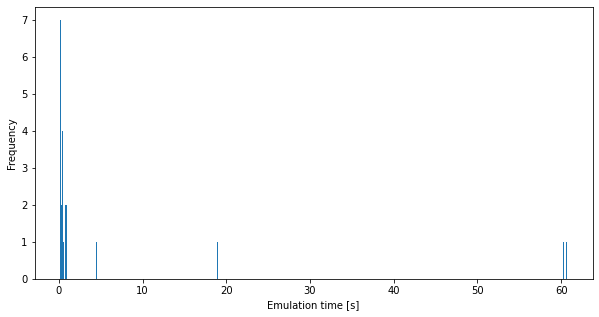

In [78]:
# report emulation times
print(f"[!] Average emulation time: {sum(emulation_times)/len(emulation_times):.2f}s")
# min and max emulation time
print(f"[!] Min emulation time: {min(emulation_times):.2f}s")
print(f"[!] Max emulation time: {max(emulation_times):.2f}s")

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel("Frequency")
ax.set_xlabel("Emulation time [s]")
_ = ax.hist(emulation_times, bins=500)

[!] Average number of API calls: 580.45
[!] Min number of API calls: 0
[!] Max number of API calls: 10001


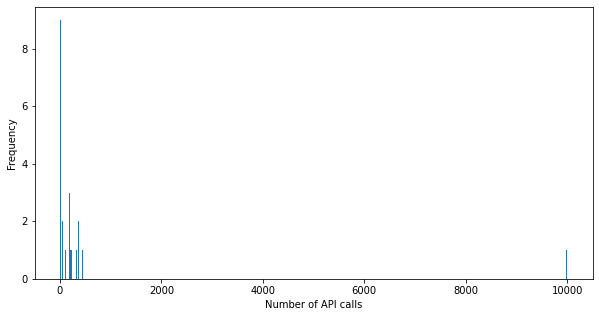

In [83]:
# show stats about api calls
api_calls = []
for report in ransomware_reports:
    api_calls.append(len(report['entry_points'][0]['apis']))

print(f"[!] Average number of API calls: {sum(api_calls)/len(api_calls):.2f}")
print(f"[!] Min number of API calls: {min(api_calls)}")
print(f"[!] Max number of API calls: {max(api_calls)}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel("Frequency")
ax.set_xlabel("Number of API calls")
_ = ax.hist(api_calls, bins=500)

In [91]:
for report in ransomware_reports:
    if 'error' in report['entry_points'][0]:
        if 'type' in report['entry_points'][0]['error']:
            if 'api_name' in report['entry_points'][0]['error']:
                print(f"Error 'unsupported_api' with: {report['entry_points'][0]['error']['api_name']} | Extracted API length: {len(report['entry_points'][0]['apis'])}")
            else:
                print(f"Error: {report['entry_points'][0]['error']['type']}")
        else:
            print(f"Error: {report['entry_points'][0]['error']}")

Error: max_api_count
Error 'unsupported_api' with: KERNEL32.SetProcessPriorityBoost | Extracted API length: 460
Error: Invalid memory fetch (UC_ERR_FETCH_UNMAPPED)
Error 'unsupported_api' with: SHLWAPI.PathFileExistsW | Extracted API length: 229
Error 'unsupported_api' with: KERNEL32.MoveFileA | Extracted API length: 375
Error: {}
Error: {}
Error: {}
Error: {}
Error 'unsupported_api' with: msvcrt.__p__environ | Extracted API length: 117
Error: {}
Error 'unsupported_api' with: ntdll.vsprintf | Extracted API length: 0
Error 'unsupported_api' with: ntdll._chkstk | Extracted API length: 0
Error: {}
Error: {}
Error: Invalid memory read (UC_ERR_READ_UNMAPPED)
Error: invalid_fetch
Error 'unsupported_api' with: gdi32.GetSystemPaletteEntries | Extracted API length: 189
Error 'unsupported_api' with: gdi32.GetSystemPaletteEntries | Extracted API length: 189
Error 'unsupported_api' with: gdi32.GetSystemPaletteEntries | Extracted API length: 189
Error: Invalid memory write (UC_ERR_WRITE_UNMAPPED)
E

## Transformer Model

Nebula uses Transformer model to classify malware, the same architecture used in GPT. Transformer is a deep learning model that is based on the attention mechanism.

In [12]:
nebula_transformer.model

TransformerEncoderChunks(
  (encoder): Embedding(50001, 64)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (ffnn): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32768, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropou

You can see that in the core of the `transformer_encoder` there is `self_attn` layer based on `MultiheadAttention` class.

### Self-attention

<img src="img/self_attn.gif" width=600>

[[Image Source]](https://medium.com/analytics-vidhya/intuitive-understanding-of-seq2seq-model-attention-mechanism-in-deep-learning-1c1c24aace1e)